In this notebook I shall implement a classification model for the dataset that I found on this website:
https://archive.ics.uci.edu/ml/datasets/adult


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./adult.csv')
print(df)

       Age          Workclass  Fnlwgt    Education  Education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

            Marital-status          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spo

In [4]:
print(df.columns)
print(df.shape)
print(df.dtypes)

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num',
       'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Income'],
      dtype='object')
(32561, 15)
Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education-num      int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-gain       int64
Capital-loss       int64
Hours-per-week     int64
Native-Country    object
Income            object
dtype: object


In [5]:
#The order of columns is an inconvenience to the way I will train the model.
#I wish to have all columns that have a string as input (eg, education) to be at one end of the feature array and numbers at the other end
#Also, Fnlwgt column at one end will also be convenient

def SwapColumns(df, c1, c2):
    '''
    Args:
    df (Dataframe) : the input data frame
    c1, c2 (int) : The indices of the columns to be interchanged
    
    Returns:
    df (Dataframe) : the updated Dataframe
    '''

    col_list = list(df.columns)
    col1 = col_list[c1]
    col2 = col_list[c2]
    col_list[c1], col_list[c2] = col_list[c2], col_list[c1]
    df[col1], df[col2] = df[col2], df[col1] #swapping the content of the columns
    df.columns = col_list #swapping the column headers
    
    return df

In [6]:
df = SwapColumns(df, 2, 13) #putting Fnlwgt at the 2nd last position
df = SwapColumns(df, 0, 9) #swapping Age with Sex (features with input data type int at the end)
df = SwapColumns(df, 4, 8) #swapping Education-num with Race
print(df)
print(df.columns)

#Now, all columns from indices 0-7 have string inputs, 8-12 have int inputs, 13 has the weights and 14 has the target variable

           Sex          Workclass  Native-Country    Education    Race  \
0         Male          State-gov   United-States    Bachelors   White   
1         Male   Self-emp-not-inc   United-States    Bachelors   White   
2         Male            Private   United-States      HS-grad   White   
3         Male            Private   United-States         11th   Black   
4       Female            Private            Cuba    Bachelors   Black   
...        ...                ...             ...          ...     ...   
32556   Female            Private   United-States   Assoc-acdm   White   
32557     Male            Private   United-States      HS-grad   White   
32558   Female            Private   United-States      HS-grad   White   
32559     Male            Private   United-States      HS-grad   White   
32560   Female       Self-emp-inc   United-States      HS-grad   White   

            Marital-status          Occupation    Relationship  Education-num  \
0            Never-married    

In [7]:
y_train = np.array(df['Income'] == ' >50K').astype(int)[:28000]
print(y_train)
'''We treat >50K as the target 1 and <=50K as the target 0'''

[0 0 0 ... 0 0 0]


'We treat >50K as the target 1 and <=50K as the target 0'

In [8]:
features_data = np.array(df)[:, :14]
features_data = np.delete(features_data, np.where(features_data == ' ?'), axis=0)
print(features_data)
print(features_data.shape)

[[' Male' ' State-gov' ' United-States' ... 0 40 77516]
 [' Male' ' Private' ' United-States' ... 0 40 234721]
 [' Female' ' Private' ' Cuba' ... 0 40 338409]
 ...
 [' Female' ' Private' ' United-States' ... 0 40 151910]
 [' Male' ' Private' ' United-States' ... 0 20 201490]
 [' Female' ' Self-emp-inc' ' United-States' ... 0 40 287927]]
(30159, 14)


In [9]:
#28000 examples are used to train and remaining ~2k examples will be used to test the model

weight_of_data = features_data[:28000, 13]
print(weight_of_data)
x_train = features_data[:28000, :13]
print(x_train.shape)
print(x_train)

[77516 234721 338409 ... 140558 303455 76855]
(28000, 13)
[[' Male' ' State-gov' ' United-States' ... 2174 0 40]
 [' Male' ' Private' ' United-States' ... 0 0 40]
 [' Female' ' Private' ' Cuba' ... 0 0 40]
 ...
 [' Male' ' Self-emp-not-inc' ' United-States' ... 0 0 40]
 [' Female' ' Local-gov' ' United-States' ... 4787 0 60]
 [' Female' ' Self-emp-not-inc' ' United-States' ... 0 0 40]]


Right now a challenge that comes to my mind is how to deal with the columns that have their feature data of object data type. 
A solution that comes to my mind is that I can sort a particular feature (example, education) in increasing order of probability of the income being >50K. Post this, I will simply assign them numbers in that order.
For eg, if we find that people with 11th education are amongst the fewest to have income >50K, followed by HS-Grad followed by Bachelors followed by Masters, we will assign the numbers

0 to 11th Education

1 to HS-Grad

2 to Bachelors

3 to Masters

for i in range (8): # 0-7 have object data type for the input feature
    input_labels = np.array(np.unique(x_train[:, i]))
    n = input_labels.shape[0] #the number of possible values
    df_temp = pd.DataFrame(np.zeros(3 * n).reshape(3,n), columns=input_labels)
    # zeros_array = np.zeros(2 * n)
    # temp = np.append(input_values, zeros_array)
    # input_values_vs_freq = temp.reshape(3, n)
    # find_where = (x_train == input_labels[0] and y_train == 1).all()
    # print(find_where)
    for j in range(x_train.shape[0]):
        df_temp[x_train[j, i]][0] += 1
        if(y_train[j] == 1):
            df_temp[x_train[j, i]][1] += 1

    for j in range(input_labels.shape[0]):
        df_temp[input_labels[j]][2] = (df_temp[input_labels[j]][1] / df_temp[input_labels[j]][0]) * 100
    print(df_temp)
    

In [10]:
'''I'm discarding the above code and replacing it with a better DataFrame design to easily implement sorting'''

Mapping_text_to_numbers = pd.DataFrame()

for i in range (8): # 0-7 have object data type for the input feature
    input_labels = np.array(np.unique(x_train[:, i]))
    n = input_labels.shape[0] #the number of possible values
    features_as_columns = input_labels.reshape(n, 1)
    temp = np.zeros(3 * n)
    temp = np.reshape(temp, (n, 3))
    feature_reshaped = np.append(features_as_columns, temp, axis=1)
    
    df_temp = pd.DataFrame(feature_reshaped, columns= ["Type", "Positive cases", "Total Cases", "Percentage Positive"])

    for j in range(x_train.shape[0]):
        idx = np.where(input_labels == x_train[j, i])[0][0]
        df_temp['Total Cases'][idx] += 1
        if(y_train[j] == 1):
            df_temp['Positive cases'][idx] += 1

    for j in range(input_labels.shape[0]):
        df_temp['Percentage Positive'][j] = (df_temp['Positive cases'][j] / df_temp['Total Cases'][j]) * 100

    '''We now have our DataFrame. We can sort it and then conditionally replace the values of our training set with a value of our choice
    We will also store the mapping for further testing of data'''

    df_temp = df_temp.sort_values(by=["Percentage Positive"])
    Mapping_text_to_numbers = pd.concat([Mapping_text_to_numbers, 
                            df_temp[ ['Type', 'Percentage Positive'] ] 
                            ]
                            )

#Here I have 2 ideas : replace the value of x with % positive value or with j. % values makes more sense
    for j in range(input_labels.shape[0]):
        x_train[(x_train[:, i] == input_labels[j]), i] = df_temp['Percentage Positive'][j]
        # x_train[ (x_train[:, i] == input_labels[j]) ] = df_temp['Percentage Positive'][j]

In [11]:
print(x_train)
print(Mapping_text_to_numbers)

[[24.232804232804234 24.64013547840813 23.885624755189973 ... 2174 0 40]
 [24.232804232804234 23.499806426635693 23.885624755189973 ... 0 0 40]
 [23.384615384615383 23.499806426635693 23.809523809523807 ... 0 0 40]
 ...
 [24.232804232804234 24.65811965811966 23.885624755189973 ... 0 0 40]
 [23.384615384615383 26.461377870563673 23.885624755189973 ... 4787 0 60]
 [23.384615384615383 24.65811965811966 23.885624755189973 ... 0 0 40]]
               Type Percentage Positive
0            Female           23.384615
1              Male           24.232804
6       Without-pay           15.384615
2           Private           23.499806
0       Federal-gov           23.522727
..              ...                 ...
2    Other-relative           23.216445
1     Not-in-family           23.926979
0           Husband           24.023556
3         Own-child           24.201681
4         Unmarried           24.296247

[98 rows x 2 columns]


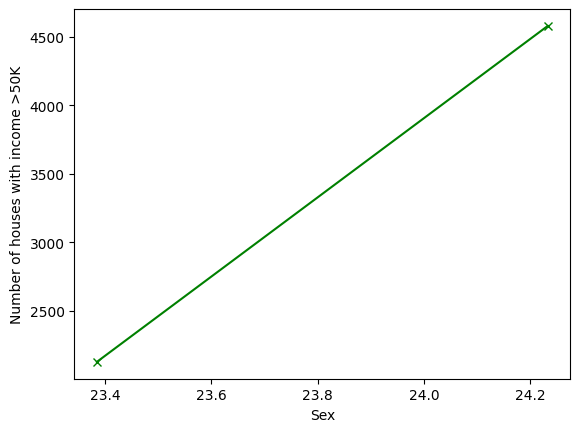

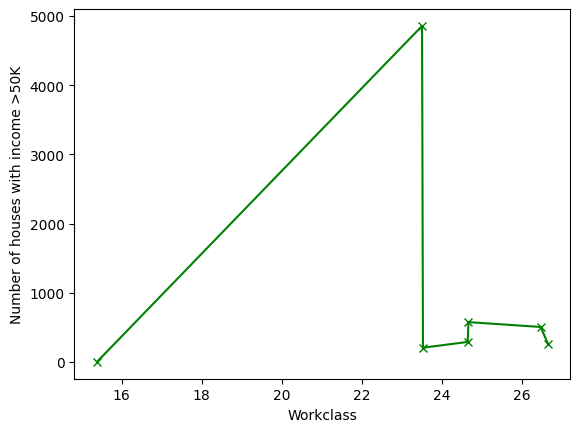

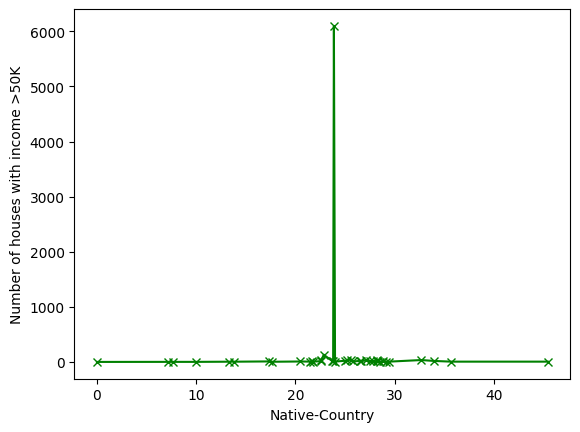

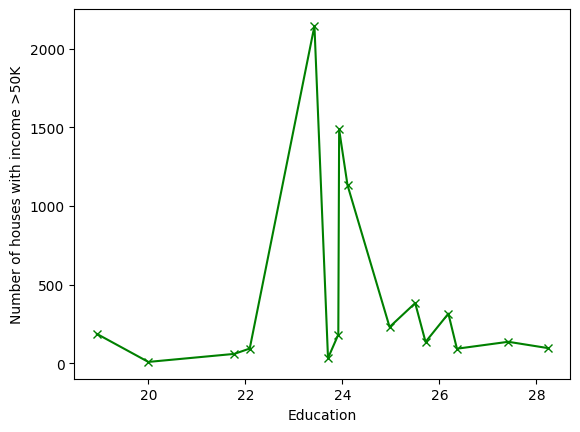

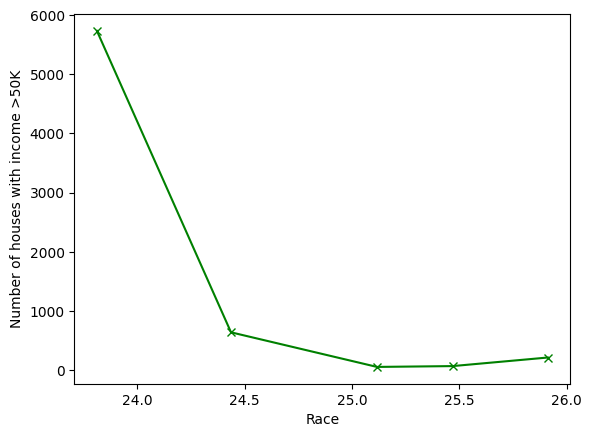

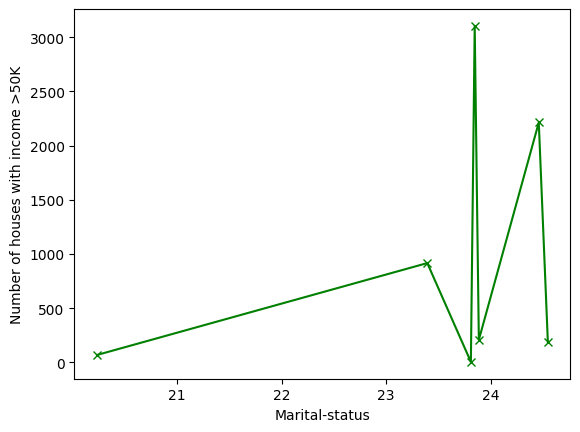

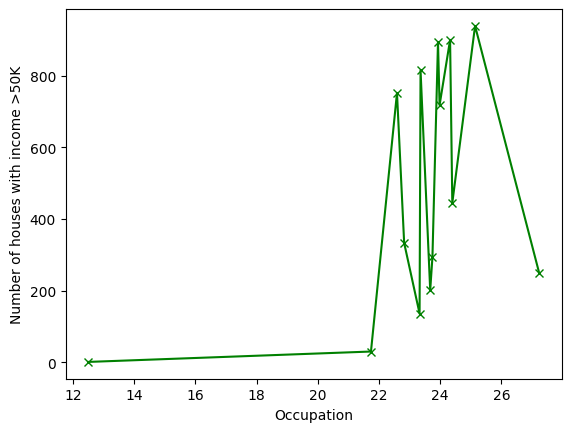

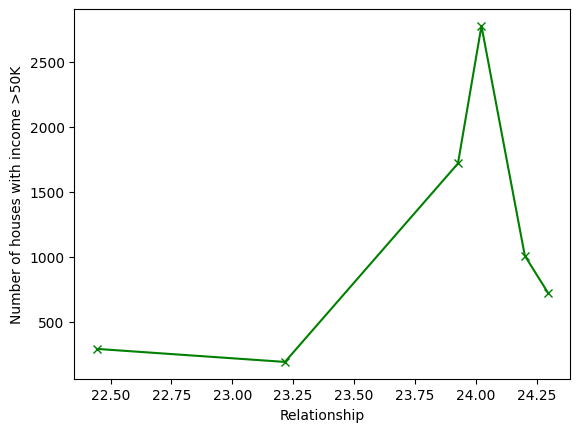

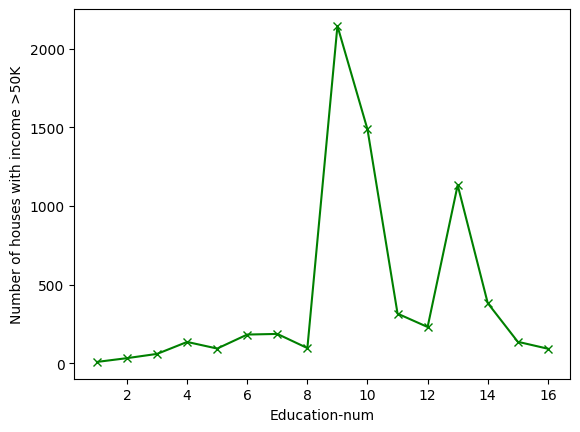

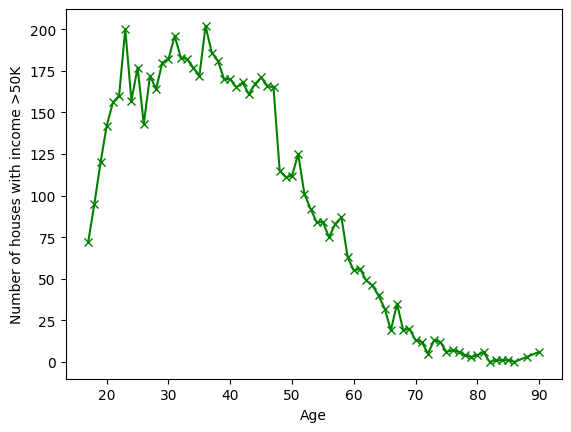

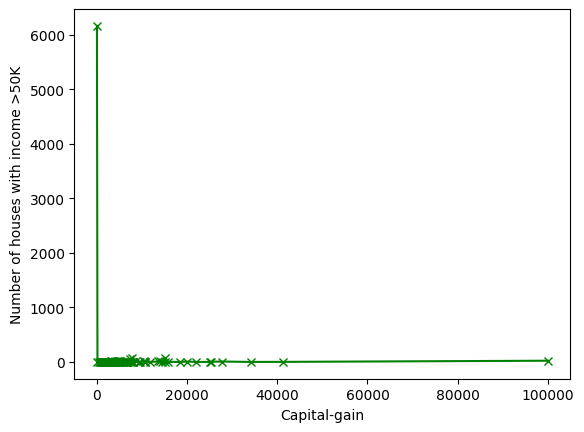

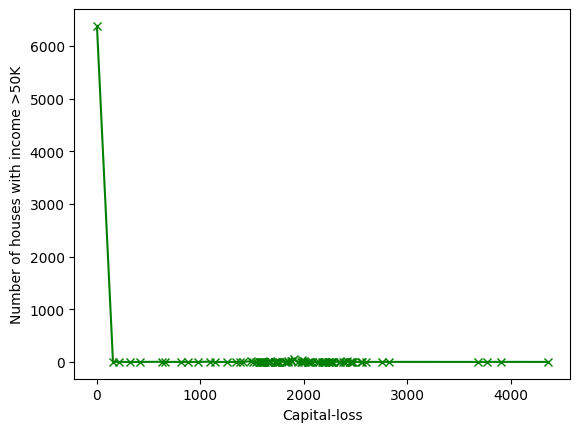

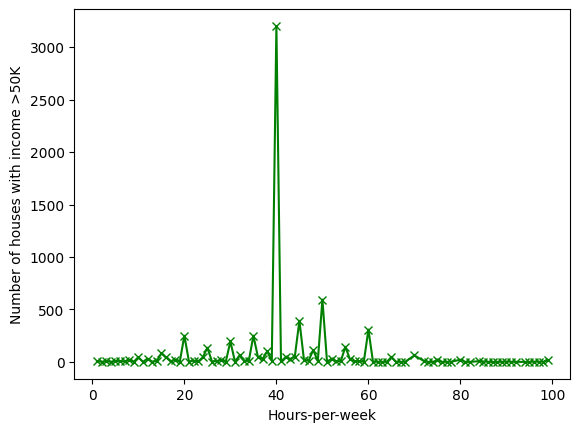

In [12]:
# for i in range(x_train.shape[1]):
#     input_labels = np.array(np.unique(x_train[:,i]))
#     freq = np.array([])
#     for j in range(input_labels.shape[0]):
#         freq = np.append(freq, np.sum(y_train[ x_train[:,i] == input_labels[j]]))
#     plt.plot(input_labels, freq, marker='x', c='g')
#     plt.xlabel(df.columns[i])
#     plt.ylabel('Number of houses with income >50K')
#     plt.show()

In [80]:
import math
def sigmoid(z):
    if(z <= -30):
        return 0.000001111111111111
    elif(z >= 30):
        return 0.999998888888888888
    else:
        f_wb = 1 / (1 + math.exp(-z))
    return f_wb

In [88]:
import math

def ComputeCost(X, y, weights, w, b):
    '''
    Args:
    X (ndarray (m,n)) : The array containing the feature data for all training examples
    y (ndarray (m,)) : The target values in the training data
    w (ndarray (n,) : The parameter of Logistic Regression Model
    b (scalar) : The parameter of Logistic Regression Model
    g (function) : The sigmoid function
    
    Returns:
    J (scalar) : Cost function for given parameters w and b
    '''

    m, n = X.shape
    J = 0
    for i in range(m):
        z_i = (np.dot(w, X[i]) + b)
        f_wb = sigmoid(z_i)
        if(y[i]):
            J += - (math.log(f_wb) * weights[i])
        else:
            J += - (math.log(1 - f_wb) * weights[i])
    J /= (np.sum(weights))


    '''
    z = np.dot(X, w) + b
    f_wb = 1 / (1 + np.exp(-z))
    J = np.sum( - (np.dot(y_train, np.log(f_wb)) + np.dot((1 - y_train), np.log(1 - f_wb))
    '''

    return J


In [89]:
m, n = x_train.shape
w = np.array([0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.5, 0.5, -0.5, 0.5, 0.5, -0.5, 0.5])
b = 0

print(ComputeCost(x_train, y_train, weight_of_data, w, b))
'''Verifying that the ComputeCost() function is working correctly'''

10.118026098789233


'Verifying that the ComputeCost() function is working correctly'

In [90]:
def ComputeGradient(X, y, weights, w, b):

    ''''
    Args:
    X (ndarray (m,n)) : The array containing the feature data for all training examples
    y (ndarray(m, )) : The target values in the training data
    w (ndarray (n,) : The parameter of Logistic Regression Model
    b (scalar) : The parameter of Logistic Regression Model
    
    Returns:
    dj_dw (ndarray (n,)) : The gradient wrt w
    b (scalar) : The gradient wrt b
    '''

    m, n = X.shape
    dJ_dw = np.zeros(n)
    dJ_db = 0

    for i in range(m):
        z_i = np.dot(w, X[i]) + b
        f_wb = sigmoid(z_i)
        for j in range(n):
            dJ_dw[j] += ((f_wb - y[i]) * weights[i]) * X[i][j] 
        dJ_db += ((f_wb - y[i]) * weights[i])

    a = np.sum(weights)
    dJ_dw /= a
    dJ_db /= a

    return dJ_dw, dJ_db

In [91]:
m, n = x_train.shape
w = np.zeros(n)
b = 0

print(ComputeGradient(x_train, y_train, weight_of_data, w, b))
'''Verifying that the ComputeGradient() function is working correctly'''

(array([  6.25149582,   6.23757543,   6.2332068 ,   6.22805211,
         6.24880271,   6.24917116,   6.23633035,   6.25060843,
         2.60832671,   9.8992203 , 329.46273791,  21.33531772,
        10.66933385]), 0.26095412828706205)


'Verifying that the ComputeGradient() function is working correctly'

In [92]:
def GradientDescent(X, y, weights, w_in, b_in, alpha = 1.0e-3, epochs = 1000):
    '''
    Args:
    X (ndarray (m,n)) : The array containing the feature data for all training examples
    y (ndarray(m, )) : The target values in the training data
    w_in (ndarray (n,) : The initial parameter of Logistic Regression Model
    b_in (scalar) : The initial parameter of Logistic Regression Model
    alpha (scalar) : learn rate of the algorithm
    epochs (scalar) : Number of iterations to train the algorithm
    
    Returns: 
    w ('''
    
    J_record = []
    w = w_in
    b = b_in

    for i in range(epochs):
        if(i % 3 == 0):
            print(f'Iteration number {i}')
        dJ_dw, dJ_db = ComputeGradient(X, y, weights, w, b)
        w = w - dJ_dw * alpha
        b = b - dJ_db * alpha

        if(i % (epochs / 200) == 0):
            J_record.append(ComputeCost(X, y, weights, w, b))
            print(f'The cost is {J_record[-1]}')
    
    return w, b, J_record

In [114]:
def PredictOutput(test, w, b):
    '''
    Args:
    test (ndarray(m,n)) : Test data with m training examples
    w (ndarray(n,) : The final parameter of the model
    b (scalar) : The final parameter of the model
    
    Returns :
    predicted_outputs(ndarray(m,)) : The target predicted by the model
    '''

    m = test.shape[0]
    predicted_outputs = []
    
    for i in range(m):
        z = np.dot(test[i], w) + b
        f_wb = sigmoid(z)
        # print(f'z is {z} and f_wb is {f_wb}')
        if(f_wb >= 0.49):
            predicted_outputs.append(1)
        else:
            predicted_outputs.append(0)
        # predicted_outputs.append(f_wb)
    
    return predicted_outputs

In [1]:
def Convert_to_Req_Format(x_test, mapping):
    m, n = x_test.shape
    for i in range(8):
        x_test[:, i] = mapping['Percentage Positive'].where(df['Type'] == x_test[:, i])
    
    return x_test

In [99]:
m, n = x_train.shape

w_initial = np.zeros(n)
b_initial = 0

print(f'Before gradient descent, cost is {ComputeCost(x_train, y_train, weight_of_data, w_initial, b_initial)}')

w_final, b_final, J_history = GradientDescent(x_train, y_train, weight_of_data, w_initial, b_initial, 4.0e-7, 50)

print(w_final)
print(b_final)

Before gradient descent, cost is 0.6931471805599475
Iteration number 0
The cost is 0.6923622656103833
The cost is 0.6888159407903447
The cost is 0.6872895825725073
Iteration number 3
The cost is 0.6866429520904433
The cost is 0.6862462562397115
The cost is 0.6858970325980477
Iteration number 6
The cost is 0.6855577062277948
The cost is 0.6852242327606776
The cost is 0.6848961667345443
Iteration number 9
The cost is 0.6845733190755529
The cost is 0.6842555208775726
The cost is 0.683942609442888
Iteration number 12
The cost is 0.68363442739252
The cost is 0.6833308224975732
The cost is 0.6830316475480936
Iteration number 15
The cost is 0.6827367602227149
The cost is 0.6824460229576871
The cost is 0.6821593028156953
Iteration number 18
The cost is 0.6818764713548914
The cost is 0.6815974044986467
The cost is 0.6813219824062287
Iteration number 21
The cost is 0.6810500893448421
The cost is 0.6807816135633376
The cost is 0.6805164471677062
Iteration number 24
The cost is 0.6802544859986802


In [115]:
test_dataset = x_train[:2000, :]
target_dataset = y_train[:2000]

# w_test = np.zeros(x_train.shape[1])
# b_test = 0

prediction = PredictOutput(test_dataset, w_final, b_final)
# print(prediction)


In [116]:
sum = 0
for i in range(2000):
    sum += prediction[i] == target_dataset[i]
print(sum / 20)

41.3
